## Load Dataset

A short script to load the data and preprocess it into a dataset

In [2]:
import numpy as np
import os
import cv2
from sklearn.utils import shuffle

In [3]:
def load_data(dir, c):
    images = []
    label = []
    for filename in os.listdir(dir):
        if filename.endswith(".jpg"): 
            im = cv2.imread(os.path.join(dir, filename)).astype(np.float32)
            images.append(im/255)
            label.append(c)
    return np.array(images), np.array(label)

In [4]:
def load_data_set(dir):
    categories = ["r0", "r1", "r2", "r3"]
    images = []
    label = []
    for i, c in enumerate(categories):
        x, y = load_data(os.path.join(dir, c), i)
        images.append(x)
        label.append(y)
    data_x = np.concatenate(images, axis = 0)
    data_y = np.concatenate(label)
    data_x, data_y = shuffle(data_x, data_y, random_state=0)
    
    size = len(data_x)
    sep = int(size*0.9)
    
    train_x = data_x[:sep]
    train_y = data_y[:sep]
    test_x = data_x[sep:]
    test_y = data_y[sep:]
    return train_x, train_y, test_x, test_y
    

## Data Visualization

Let us visualize the data to gain a better understanding of it

In [5]:
import matplotlib.pyplot as plt

In [27]:
train_x, train_y, test_x, test_y = load_data_set('4 categories')

In [6]:
def visualize(x, y):
    imgplot = plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    plt.title("Category:" + str(y))
    plt.show()

In [7]:
def visualize_dataset(train_x, train_y):
    categories = [0, 1, 2, 3]
    for c in categories:
        for i in xrange(len(train_y)):
            if train_y[i] == c:
                visualize(train_x[i], train_y[i])
                break

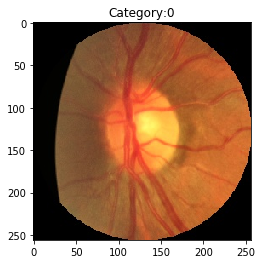

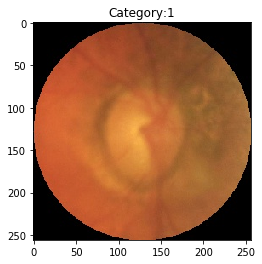

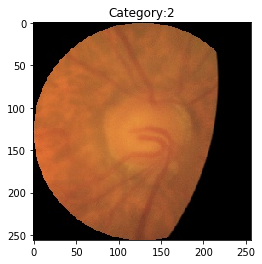

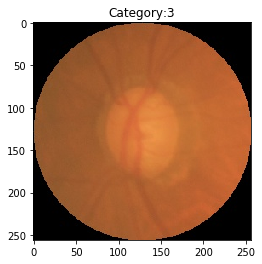

In [9]:
visualize_dataset(train_x, train_y)

As seen in the images above, by comparing the different categories side by side, corneal image in the category with higher number seems to be cloudier than the others.

## Baseline Model

To measure the difficulty of the dataset for classification, I will use a 2 layer convolutional neural net to see how well a naive approach will perform on this dataset

In [8]:
import tensorflow as tf

/home/dronchego/.virtualenvs/deepLearning/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
tf.__version__

'1.5.0'

In [10]:
def BaseLineModel(features, labels, mode):
    
    input_layer = features['x']
    
    with tf.variable_scope('conv1') as scope:
        conv = tf.layers.conv2d(inputs = input_layer,
                                filters = 64,
                                kernel_size = [5, 5],
                                strides = (2,2),
                                padding = 'same',)
        norm = tf.layers.batch_normalization(inputs = conv)
        conv1 = tf.nn.relu(norm, name=scope.name)
    
    pool1 = tf.layers.max_pooling2d(inputs = conv1,
                                   pool_size = [3,3],
                                   strides = [2,2],
                                   name = 'pool1')
    
    with tf.variable_scope('conv2') as scope:
        conv = tf.layers.conv2d(inputs = input_layer,
                                filters = 64,
                                kernel_size = [5, 5],
                                strides = (1,1),
                                padding = 'same',)
        norm = tf.layers.batch_normalization(inputs = conv)
        conv2 = tf.nn.relu(norm, name=scope.name)
    
    
    pool2 = tf.layers.max_pooling2d(inputs = conv2,
                                   pool_size = [3,3],
                                   strides = [2,2],
                                   name = 'pool2')
    
    with tf.variable_scope('local3') as scope:
        pool2_flat = tf.layers.flatten(pool2)
        dense = tf.layers.dense(inputs=pool2_flat, units=512, activation=tf.nn.relu)
        dropout3 = tf.layers.dropout(
              inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN, name=scope.name)
    
    with tf.variable_scope('local4') as scope:
        dense = tf.layers.dense(inputs=dropout3, units=256, activation=tf.nn.relu)
        dropout4 = tf.layers.dropout(
              inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN, name=scope.name)
    
    logits = tf.layers.dense(inputs=dropout4, units=4, name="logits")
    
    
    predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [11]:
def main(unused_argv):
    
    train_data, train_labels, eval_data, eval_labels = load_data_set('4 categories')

    base_line_classifier = tf.estimator.Estimator(
        model_fn=BaseLineModel, model_dir="/home/dronchego/medical_imaging/base_line/")
    
    tensors_to_log = {"probabilities": "softmax_tensor"}
    
    logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)
    
#     writer = tf.summary.FileWriter("/home/dronchego/har-classification/", graph=sess.graph)
    
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=100,
      num_epochs=None,
      shuffle=True)
    
    base_line_classifier.train(
      input_fn=train_input_fn,
      steps=20000,
      hooks=[logging_hook])

    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_results = base_line_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)


In [ ]:
tf.app.run()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f15b6889c90>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/home/dronchego/medical_imaging/base_line/', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
